- I try this time new format for the inputs of the NLLLoss (prediction and target) and a new optimization loop
- I want to reimplment the class calling in the main class model
- I want to try to optimize accross target
- I try to get inspiration from Alex code organisation
- I try to simplify and use easy operation
- remove function I used before and I don t need anymore (like plot IO)

## Import

In [10]:
import pandas as pd
import numpy as np
import math
import sys 
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss F.softmax
import torch.optim as optim #optim.sgd
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset
import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.interpolate import griddata
from scipy import special

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from icecream import ic  # for debugging. print variable name

from PC_param import default_parameters_network # To get the parameters
pars = default_parameters_network()

## Functions

In [11]:
""" Plot HeatMap of firing rate function"""
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)
    rE_df.index = rE_df.index + 1
    rI_df.index = rI_df.index + 1
    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time ms", "Time ms"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()
    plt.show()


""" Filters gauss and Dog and LoG"""
def gaussian_filter(s, N):
    pop = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2

def dog_filter(sOut, N):
    sIn = sOut / 30
    pop = np.arange(1, N + 1)
    gaussIn = np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog

def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""
 Normalization or transform to probability
"""

def make_it_proba(r_e):
    eps = torch.FloatTensor([sys.float_info.epsilon]) #torch.FloatTensor
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
 
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_r_e) #r_e_max.sum())
    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)


''' Classic Normalization
use:
#preprocessing.normalize(re_numpy, axis= 0)[20,:].sum()

or use:
'''
def normalize(x):
    N = (x - x.min()) / (x.max() - x.min())
    return N


"""
Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""
def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation

def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  
    return torch.tensor(y)

def replace_argmax(r):
    # along some dimension (e.g., the last dimension).
    indices = torch.arange(r.shape[-1]).to(r.device)
    return torch.gather(indices, dim=-1, index=torch.argmax(r, dim=-1)).max()




""" Target design: Get the expected stimuli and then create a matrix of 1 where stimuli 0 elsewhere"""

def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1) #consider replacing argmax by replace_argmax
    Xmax = torch.max(Xargmax)
    return Xmax

def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable
    
    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)# replace where function by relu functio which is differentiable
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d



""" 
Optimization function
Make a function which save parameters of trained model and upload the new model with the updated parameters
"""

def model_with_saved_trained_param(old_model, optimizer, Model, param, sim, dicJ):
    # or to save the parameters only
    torch.save(old_model.state_dict(),"Old_model_optimized_parameters.pth")
    torch.save(optimizer.state_dict(),"optimizer_optimized_parameters.pth")
    #load these parameters in a new model instance
    new_mymodel = Model(param, sim, dicJ)
    new_mymodel.load_state_dict(torch.load("Old_model_optimized_parameters.pth")) 
    optimizer.load_state_dict(torch.load('optimizer_optimized_parameters.pth'))

    #print(optimizer.param_groups[0]['params'])
    if old_model.Jee == new_mymodel.Jee:
        print("it works")
    print("old model Jee:",old_model.Jee,"new model Jee:", new_mymodel.Jee)
    #print(optimizer.param_groups)
    #print(optimizer.state)
    return new_mymodel, optimizer


def load_weights(newmodel, modelpath): #string
        if '.pt' not in modelpath:
            modelpath += '.pt'      
        newmodel.load_state_dict(torch.load(modelpath))
        #new_mymodel = Model(param, sim, model.state_dict())
        return newmodel #, newmodel.state_dict() to access the param
    
def save_weights(oldmodel, modelpath, epoch=None):  #string
    if '.pt' not in modelpath:
            modelpath += '.pt'
    torch.save(oldmodel.state_dict(), modelpath)

    

"""
Model evaluation

function wich test the accuracy of a model with new parameters compared to expected results + loss values for every samples
"""
def test_model(model, test_dataloader, loss_f):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            # Calculate output
            Y_prediction, _, dredt, dridt = model(x_test[0])
            #Y_prediction_prob = make_it_proba(Y_prediction)

            # Calculate loss
            #loss = loss_f(Y_prediction_prob, y_test[0], dredt, dridt)
            loss = loss_f(Y_prediction, y_test[0], dredt, dridt)

            # Accuracy
            predictions = Y_prediction.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            #predictions = Y_prediction_prob.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            correct_predictions += (predictions == y_test[0]).sum().item() # calculates the number of correct predictions by comparing the rounded predictions with the true labels (y_test). It sums up the correct predictions over the batch.
            total_samples += y_test[0].numel() # adds the total number of samples/item in the current batch to the overall count.

            test_loss += loss.item()

    accuracy = correct_predictions / total_samples
    average_loss = test_loss / len(test_dataloader)

    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {average_loss:.4f}')
    return accuracy, average_loss



""" 
LOSS
"""

def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)


- replace argmax by replace_argmax
- do like alex for the save and load parameters (load_weights): make 2 seperated functions included into the class model . if modelpath exists,then the old parameter are called
https://github.com/qtabs/goin/blob/main/goin.py

- consider making a class "create a target" .  this can be more dynamic 

## Class

### Simple Class

In [12]:

# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°
    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']
    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    #°°° Hard encode these parameters °°°
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    #N=20, sIn=.1, sOut=3., sEI=.2
    def __init__(self, sEI=.2, sIn=.1, sOut=3., N=20):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("Time step of the simulation (dt):", self.dt, "  Duration of simulation (T):", self.T,"s",
              "  Length of the time frame (Lt):", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=0, dur=0.05):#ISI=0.5, dur=0.2): #ISI=1, dur=0.2   # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        #f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f: #+2 to not lose dimension ! becareful! 
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt)+2, 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
    
        f_stim = fx_array # np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1
        #ic(len(f_stim))

    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, N=20, f_stim=None, InMax=None, In0=None):
        paramf = np.arange(1, N+1)
        
        #mask the ground truth f_stim by a gaussian function
        w = np.exp(-(((paramf) - (self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N
        #ic((w).shape)
        #if I want to normalize w:
        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N +1, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        len_sim = len(range_sim)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, len_sim ,w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI,"s","  Size In", self.In.shape, "Size w:",
              self.w.shape, "  f_stim = total length simulation:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




### Classs Model

In [13]:
""""""
"""""*
*
***********  CLASS MYMODEL
*
*"""""
"""


class Model(nn.Module):
    def __init__(self, param, sim, dicJ):
        super(Model, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = sim.dt #torch.tensor(1e-4) #
        self.N = param.N #20
        self.taue = self.taui = torch.tensor(param.taue) #torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(param.ae)# 18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(param.be) #-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(param.hme)#78.67)
        self.ai = torch.tensor(param.ai)#21.97)
        self.bi = torch.tensor(param.bi)#-4.81)
        self.hmi = torch.tensor(param.hmi)#125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        #self.dicJ = dicJ #kwargs
        #    self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        #self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        #self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        #self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        #self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))

        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True, dtype=torch.float64))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True, dtype=torch.float64))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True, dtype=torch.float64))
 
 
    def load_weights(self, modelpath): #string
        self.model.load_state_dict(torch.load(modelpath))
        self.model.gru.flatten_parameters() 
    
    def save_weights(self, modelpath, epoch=None):  #string
         torch.save(self.model.state_dict(), modelpath)
          
		

    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.
        mulaI =torch.mul(a, I_tot)
        addB= mulaI + b
        expo = torch.exp(- (addB))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            i_tot_e = (self.Jee * s_ampa) - (self.Jie * s_gaba_wie) + (self.Jin*  In[k - 1, :])
            i_tot_i = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba


        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt"""


"\n\n\nclass Model(nn.Module):\n    def __init__(self, param, sim, dicJ):\n        super(Model, self).__init__()\n\n        #--- Define other model parameters, layers, or components here if needed\n        self.dt = sim.dt #torch.tensor(1e-4) #\n        self.N = param.N #20\n        self.taue = self.taui = torch.tensor(param.taue) #torch.tensor(0.005)\n         # ¤ parameter of the phi function Not tweakable parameters\n        self.ae = torch.tensor(param.ae)# 18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton\n        self.be = torch.tensor(param.be) #-5.38)  # Threshold of the E populaiton\n        self.hme = torch.tensor(param.hme)#78.67)\n        self.ai = torch.tensor(param.ai)#21.97)\n        self.bi = torch.tensor(param.bi)#-4.81)\n        self.hmi = torch.tensor(param.hmi)#125.62)\n        #create the smallest possible number\n        self.epsilon = sys.float_info.epsilon\n\n        self.sIn = torch.tensor(.1)\n        self.sOut= 3.\n        self.sEI 

In [14]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class Model(nn.Module):
    def __init__(self, param, sim, dicJ):
        super(Model, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = sim.dt #torch.tensor(1e-4) #
        self.N = param.N #20
        self.taue = self.taui = torch.tensor(param.taue) #torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(param.ae)# 18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(param.be) #-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(param.hme)#78.67)
        self.ai = torch.tensor(param.ai)#21.97)
        self.bi = torch.tensor(param.bi)#-4.81)
        self.hmi = torch.tensor(param.hmi)#125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.dicJ = dicJ #kwargs
        """    self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))"""

        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True, dtype=torch.float64))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True, dtype=torch.float64))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True, dtype=torch.float64))

        #--- Initialize model variables here
    def initiate_state(self):
        self.prev_r_e = torch.zeros((self.N)) # torch.ones(self.N) shows more obvious results
        self.prev_r_i = torch.zeros((self.N))
        self.prev_s_ampa = torch.zeros((self.N))
        self.prev_s_gaba = torch.zeros((self.N))
        self.dr_e_dt = torch.zeros((self.N))
        self.dr_i_dt = torch.zeros((self.N))
        self.s_ampa = torch.tensor(0.)
        self.i_tot_e = torch.tensor(0.)
        self.i_tot_i = torch.tensor(0.)
		

    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.
        mulaI = a * I_tot
        addB = mulaI + b
        expo = torch.exp(-addB)
        return hm / (1 + expo)
        """mulaI =torch.mul(a, I_tot)
        addB= mulaI + b
        expo = torch.exp(- (addB))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))"""

    def forward(self, In):
        #--- Compute values of interest
        #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
        s_gaba_wie = self.prev_s_gaba @ self.wie
        s_ampa_wei = self.prev_s_ampa @ self.wei
        s_gaba_wii = self.prev_s_gaba @ self.wii
        JeeAmpa =  torch.mul(self.Jee, self.s_ampa)
        self.i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In))
        self.i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))
        #print("Jee after computation", self.Jee.grad_fn)
        """self.i_tot_e = (self.Jee * self.s_ampa) - (self.Jie * s_gaba_wie) + (self.Jin*  In)
        self.i_tot_i = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)"""

        phi_arr_e = self.phi(self.i_tot_e, self.ae, self.be, self.hme)
        phi_arr_i = self.phi(self.i_tot_i, self.ai, self.bi, self.hmi)

        self.dr_e_dt = (-self.prev_r_e + phi_arr_e) / self.taue
        self.dr_i_dt = (-self.prev_r_i + phi_arr_i) / self.taui

        r_e = self.prev_r_e+ self.dr_e_dt * self.dt
        r_i = self.prev_r_i + self.dr_i_dt * self.dt

        dS_amp_dt = (- self.prev_s_ampa / self.tauAMPA) + r_e
        s_ampa = self.prev_s_ampa+ dS_amp_dt * self.dt

        dS_gab_dt = (- self.prev_s_gaba / self.tauGABA) + r_i
        s_gaba = self.prev_s_gaba + dS_gab_dt * self.dt

        self.prev_r_e = r_e
        self.prev_r_i = r_i
        self.prev_s_ampa = s_ampa
        self.prev_s_gaba = s_gaba


        return self.prev_r_e, self.prev_r_i, self.dr_e_dt, self.dr_i_dt, self.prev_s_ampa, self.prev_s_gaba

## Create Input stimuli

In [15]:
# \\\\ Parameters
param = Parameter() # N=20

# \\\\ Simulation time: T in s  (2s before)
sim = Simulation(dt=1e-4,T=.0510) 
sim.printSim()

# \\\\ Bottom up sensory input
stimuli = Stim(param, sim, dur=sim.T, f=[8])
In, range_sim, len_sim, w, sigmaIn = stimuli.sensoryInput(param, sim, sigmaIn=2.) #2.
stimuli.printStim()
print((len_sim))

Time step of the simulation (dt): 0.0001   Duration of simulation (T): 0.051 s   Length of the time frame (Lt): 510
frequence of stimulus f: [8]   ISI: 0 s   Size In (510, 20) Size w: (510, 20)   f_stim = total length simulation: (510, 1) sigmaIn: 2.0
510


In [16]:
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J_list = list(J1.keys())
print(J1['Jee'], J_list)

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
model = Model(param=param, sim=sim, dicJ=J1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
#r_e, r_i, dredt, dridt = mymodel.forward(sti)

#HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)
#HeatMap(sti.detach().numpy(), r_i.detach().numpy(), J1)

0.072 ['Jee', 'Jei', 'Jie', 'Jii', 'Jin']


## Data preparation - Batch

#### 1- create a big dataset for every stimuli . In = X stimulus

#### 2- Split In/ X into train and test dataset

Split 70% into train dataset and 30% into test dataset

#### 3- get expected Y - Ytarget

#### 4- Create the DataLoader merging Xtrain_tensor and Ytrain_tensor (Input and Target)

In [17]:
 # 1  \\\\\\\\\\\ BIG Bottom up sensory input
def IN_Big(param, simu, len_sim):
    IN_T = torch.zeros(len_sim, 20 ,20)

    for i in range(0, param.N):
        index = i+1
        st = Stim(param,simu, dur=simu.T,f =[index], ISI=0) 
        In, range_s, len_s, w, sigmaIn =st.sensoryInput(param, simu, sigmaIn = 2.)
        IN_T[:,:, i] = torch.tensor(In)
        #sti = torch.tensor(In).float()

    return IN_T

# 2
def train_test_dataset(IN_T):
    #create a random list containing each of our stimuli types
    rng = np.random.default_rng(1245)
    Number_Stim = (IN_T).shape[2]
    rand_indices = np.arange(0, Number_Stim)
    rng.shuffle(rand_indices)

    # split this random list into test and train index. and filter the IN with those indexes
    val_split_index = int(np.floor(0.7 * Number_Stim))
    test_idx, train_idx = rand_indices[val_split_index:], rand_indices[:val_split_index]
    train_tensorIN = IN_T[:,:, train_idx]
    test_tensorIN = IN_T[:,:, test_idx]

    return train_tensorIN.permute(2,0,1), test_tensorIN.permute(2,0,1)


# 3
def Y_Target_Big(X_tensor):
    Ytrain_tensor = torch.zeros((X_tensor.shape))
    for stimu in range(X_tensor.shape[0]):
      Ytrain_tensor[stimu,:,:] = get_expected_Y_relu(X_tensor[stimu,:,:])
    return Ytrain_tensor


# 4
def create_dataloader(Input, Target):
    train_dataset = TensorDataset(Input, Target)
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle = True) #one sample per batch
    return train_dataloader

# 5
def fromIN_to_dataloader(IN_T):

    train_tensIN, test_tensIN = train_test_dataset(IN_T)
    #print(train_tensorIN[:,:,0])
    #plt.plot(np.arange(0,20),train_tensorIN[4,300,:]) 
    Ytrain_tensor = Y_Target_Big(train_tensIN)
    Ytest_tensor = Y_Target_Big(test_tensIN)
    train_dataloader = create_dataloader(train_tensIN, Ytrain_tensor)
    test_dataloader = create_dataloader(test_tensIN, Ytest_tensor)
    return train_dataloader, Ytrain_tensor, train_tensIN, test_dataloader, Ytest_tensor, test_tensIN

In [18]:
IN_T = IN_Big(param=param, simu=sim, len_sim = sim.Lt)

train_dataloader, Ytrain_tensor, Xtrain_tensor, test_dataloader, Ytest_tensor, test_tensorIN = fromIN_to_dataloader(IN_T=IN_T)

#### Control what I have inside my tensors

ic| X_input_proba.shape[1]: 20


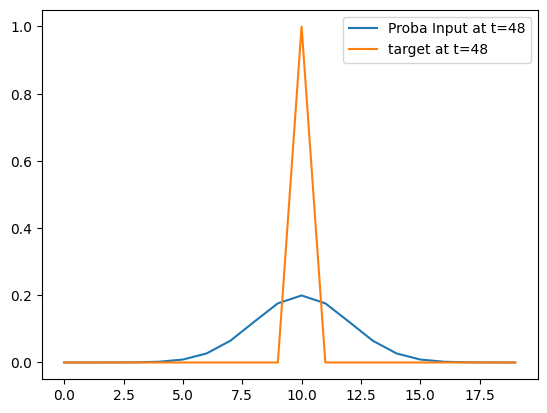

In [19]:

X_input_proba = make_it_proba(Xtrain_tensor[4,:,:])
Y_target = Ytrain_tensor[4,:,:]
t=48
ic(X_input_proba.shape[1])
plt.plot(torch.arange(X_input_proba.shape[1]), X_input_proba[t,:], label= f"Proba Input at t={t}") #not in proba
plt.plot(torch.arange(Y_target.detach().numpy().shape[1]), Y_target.detach().numpy()[t,:], label = f"target at t={t}") #in proba
plt.legend()

### Make the target vector: index of the activated population at each time step and across each batch (B*T)

In [20]:
def make_Target_index(IN_T):
    BatchXTime = IN_T.shape[0]*  IN_T.shape[1]
    Target_index = torch.zeros((BatchXTime))
    time_stim = 0
    for batch in range(0, IN_T.shape[0]):
        for time in range(0, IN_T.shape[1]):
            Target_index[time + time_stim] = get_stimuli_input(IN_T[batch,:,:]).item()
        time_stim += IN_T.shape[1]
    
    #print(len(Target_index))
    #print(Target_index.numpy()[0])
    return Target_index

Target = make_Target_index(Xtrain_tensor)#plt.plot(np.arange(0,Target_index.shape[0]),Target_index)

#### Make the input vector of the shape (B*T,N)

In [40]:
Input = Xtrain_tensor.reshape(Xtrain_tensor.shape[0] * Xtrain_tensor.shape[1], Xtrain_tensor.shape[2])
#plt.plot(np.arange(20),Xtrain_forloss[2000,:])
print(Xtrain_tensor.shape, Input.shape)


torch.Size([14, 510, 20]) torch.Size([7140, 20])


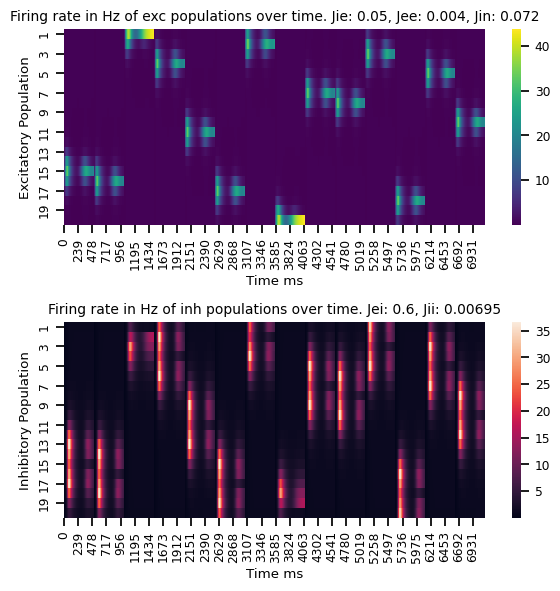

In [22]:
count = 0 
P0 = torch.zeros(Input.shape)  
I0 = torch.zeros(Input.shape)
model.initiate_state()
for i, b in enumerate(Target):
        count +=1
        P0[i,:], I0[i,:], dredt, dridt, ampa, gaba = model.forward(Input[int(i),:])#.item()
        if count == Xtrain_tensor.shape[1]: #if we end the simulation time and go to the next batch
            count = 0
            model.initiate_state()

HeatMap(P0.detach().numpy(), I0.detach().numpy(), J1)

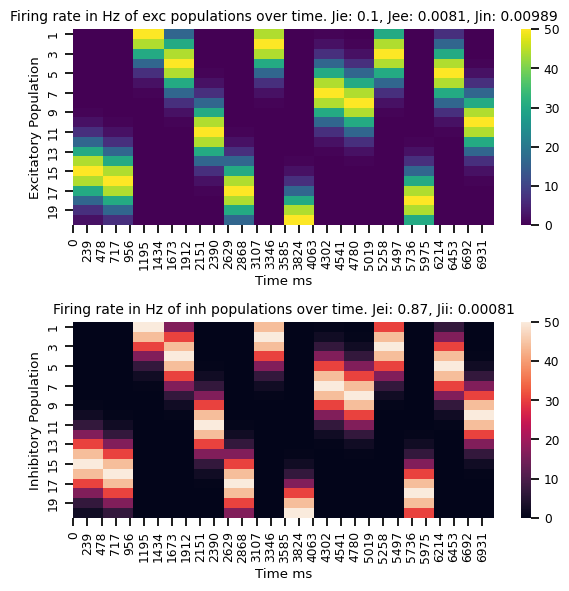

In [23]:
#Input_forloss.shape
HeatMap(Input.detach().numpy(), Input.detach().numpy())
#plt.plot(np.arange(Input.shape[1]), Input[1500,:].detach().numpy())


## Optimization

In [24]:
def make_it_proba(r_e):
    eps = torch.FloatTensor([sys.float_info.epsilon]) #torch.FloatTensor
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
 
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_r_e) #r_e_max.sum())
    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

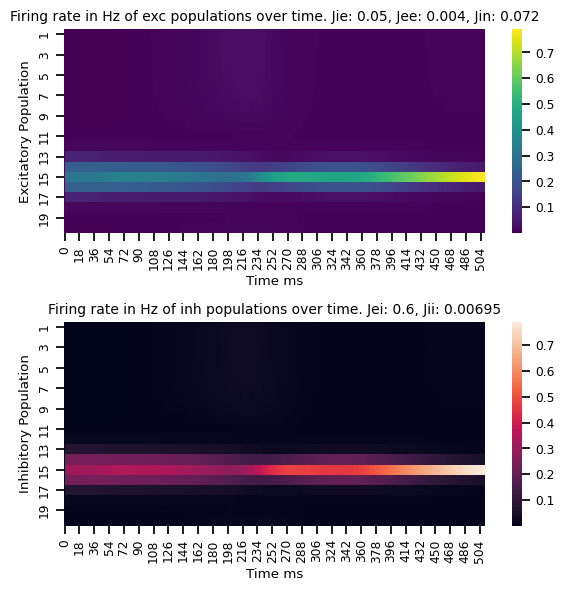

In [25]:
P0_norm = make_it_proba(P0)
HeatMap(P0_norm[:510,:].detach().numpy(),P0_norm[:511,:].detach().numpy() , J1)
#HeatMap(P0_norm[1100:1511,:].detach().numpy(),P0_norm[:511,:].detach().numpy() , J1)
#plt.plot(np.arange(P0_norm.shape[1]), P0_norm[504,:].detach().numpy())


In [26]:
model = Model(param=param, sim=sim, dicJ= J1)
model.initiate_state()
num_epoch = 25
losses = torch.zeros(num_epoch)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.NLLLoss()
logsoft = nn.LogSoftmax(dim=1)
learning_rate =0.0001
optimizer = optim.Adam(model.parameters(),
                      lr=learning_rate) 
"""optim.SGD(model.parameters(),
                      lr=0.0001, weight_decay = 0.001)""" 
T = make_Target_index(Xtrain_tensor)

model.train()
for epoch in range(num_epoch):
    model.initiate_state()
    optimizer.zero_grad()  
    P = torch.zeros(Input.shape)   
    I = torch.zeros(Input.shape)   
    count = 0
    for i, b in enumerate(T):
        count +=1
        P[i,:], I[i,:], dredt, dridt, ampa, gaba = model(Input[int(i),:])
        if count == Xtrain_tensor.shape[1]: #if we end the simulation time and go to the next batch
            count = 0
            model.initiate_state()
    
    #P2 = pred_pop_log = F.softmax(P, dim=1)
    #P2 = logsoft(P)#.t()
    P2 = make_it_proba(P)
    loss = criterion(P2, T.long())
    #loss = criterion(P, T.long()) # #criterion(P2, T.long()) # 
    loss.backward()
    optimizer.step()
    losses[epoch] = loss
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}')#.item()
    print("total_loss.grad: ",loss.grad_fn)
    #print("after optimizer.step()", model.Jee.grad)
    for par in model.parameters():
      print(par.grad)

save_weights(model, "Optimized.pth")

Epoch [1/25], Loss: -0.49087226390838623
total_loss.grad:  <NllLossBackward0 object at 0x0000017FE1C4F010>
tensor(0., dtype=torch.float64)
tensor(6.8478, dtype=torch.float64)
tensor(0.4172, dtype=torch.float64)
tensor(-0.0267, dtype=torch.float64)
tensor(5.4868, dtype=torch.float64)
Epoch [2/25], Loss: -0.49180519580841064
total_loss.grad:  <NllLossBackward0 object at 0x0000017FE1D41390>
tensor(0., dtype=torch.float64)
tensor(4.9350, dtype=torch.float64)
tensor(0.3643, dtype=torch.float64)
tensor(-0.0213, dtype=torch.float64)
tensor(0.5420, dtype=torch.float64)
Epoch [3/25], Loss: -0.49213942885398865
total_loss.grad:  <NllLossBackward0 object at 0x0000017FD45CB2B0>
tensor(0., dtype=torch.float64)
tensor(3.3848, dtype=torch.float64)
tensor(0.3256, dtype=torch.float64)
tensor(-0.0172, dtype=torch.float64)
tensor(-3.4950, dtype=torch.float64)
Epoch [4/25], Loss: -0.49238553643226624
total_loss.grad:  <NllLossBackward0 object at 0x0000017FD45CB2B0>
tensor(0., dtype=torch.float64)
tensor(2

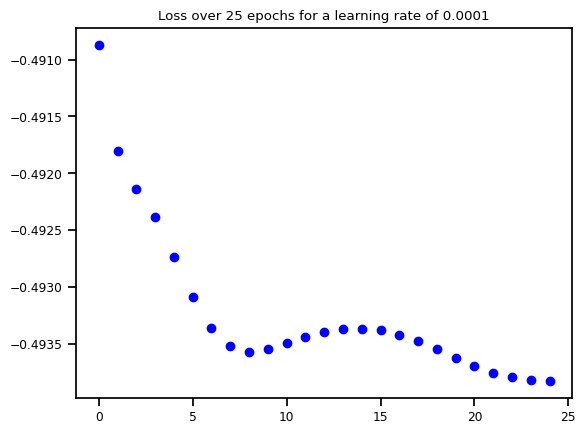

In [27]:
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epoch} epochs for a learning rate of {learning_rate}")
plt.show()

### Check new parameters 

In [ ]:
newModel = Model(param, sim, J1)
trained_model = load_weights(newModel, "Optimized.pth")

ic(trained_model.state_dict(), J1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
trained_model.initiate_state()
count = 0
P_t = torch.zeros(Input.shape)  
I_t = torch.zeros(Input.shape)
for i, b in enumerate(T):
        count +=1
        P_t[i,:], I[i,:], dredt, dridt, ampa, gaba = trained_model(Input[int(i),:])#.item()
        if count == Xtrain_tensor.shape[1]: #if we end the simulation time and go to the next batch
            count = 0
            trained_model.initiate_state()



In [34]:
print(torch.max(P0[:500,:]), torch.max(P_t[:500,:]))

tensor(32.9685, grad_fn=<MaxBackward1>) tensor(34.7111, grad_fn=<MaxBackward1>)


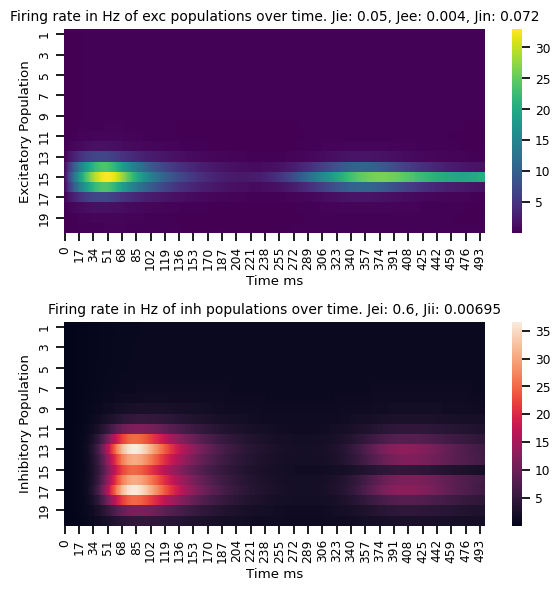

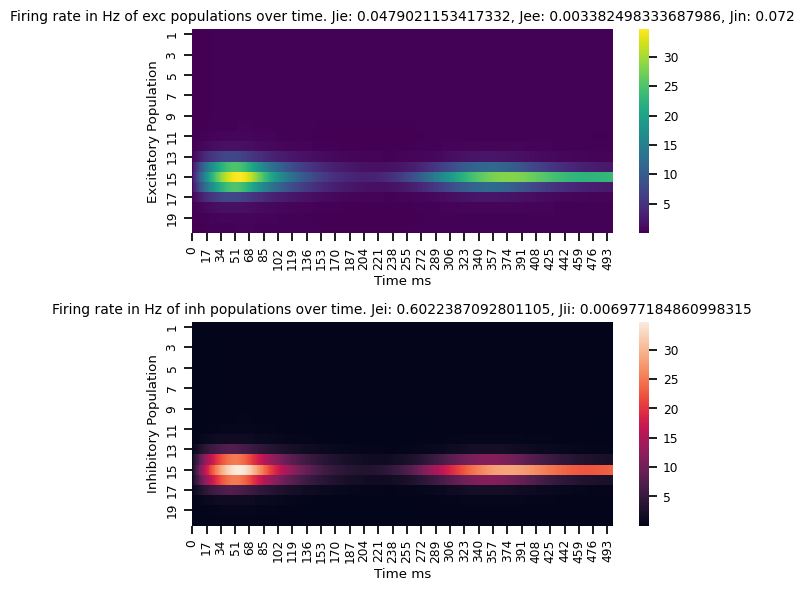

In [33]:
#[:500,:]
HeatMap(P0[:500,:].detach().numpy(), I0[:500,:].detach().numpy(), J1)
#[:500,:]
J2= {'Jee': trained_model.Jee.detach().numpy(), 'Jei': trained_model.Jei.detach().numpy(), 'Jie': trained_model.Jie.detach().numpy(), 'Jii': trained_model.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(P_t[:500,:].detach().numpy(), P_t[:500,:].detach().numpy(), J2)

### Compare normalized data

ic| r_e_trained[i,:].shape: torch.Size([20])


[ 0.12295689  0.12295584  0.12295473  0.12295334  0.12295318  0.12297559
  0.12319409  0.12462706  0.13184266  0.16227047  0.28903887  0.9421422
  4.83757    15.149137   19.767359   15.14917     4.8376174   0.9421593
  0.28904623  0.1622757 ]


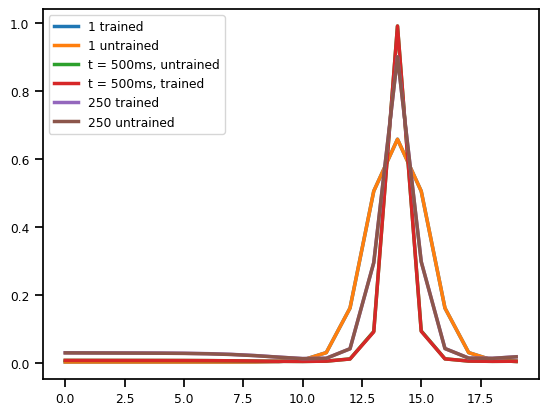

In [39]:
t = 1
t2 = 500
t3 = 250
r_e_trained = P_t

from sklearn import preprocessing
re_numpy = np.array(P.detach().numpy())
re_numpy_train = np.array(r_e_trained.detach().numpy())
print(np.array(re_numpy[20,:]))


re_tr_norm = preprocessing.normalize(re_numpy_train, axis= 1) #torch.zeros(r_e_trained.shape)
re_norm = preprocessing.normalize(re_numpy, axis= 1) #torch.zeros(r_e_trained.shape)
ic(r_e_trained[i,:].shape)

"""for i in range(r_e_trained.shape[0]):
    re_tr_norm[i,:] = preprocessing.normalize(r_e_trained[i,:].detach().numpy())# / retrained_t2[i,:].sum()
    re_norm[i,:] = preprocessing.normalize(r_e[i,:])# / r_e[i,:].sum()
"""

plt.plot(np.arange(r_e_trained.shape[1]), re_tr_norm[t,:], label = f"{t} trained")
plt.plot(np.arange(r_e_trained.shape[1]), re_norm[t,:], label = f"{t} untrained")

plt.plot(np.arange(r_e_trained.shape[1]), re_norm[t2,:], label = f"t = {t2}ms, untrained")
plt.plot(np.arange(r_e_trained.shape[1]), re_tr_norm[t2,:], label = f"t = {t2}ms, trained")

plt.plot(np.arange(r_e_trained.shape[1]), re_tr_norm[t3,:], label = f"{t3} trained")
plt.plot(np.arange(r_e_trained.shape[1]), re_norm[t3,:], label = f"{t3} untrained")

#plt.plot(np.arange((r_e_bad[t,:].detach().numpy()).shape[0]), r_e_bad[t,:].detach().numpy(), label = f"bad {t}")
#plt.plot(np.arange((r_e_bad[t2,:].detach().numpy()).shape[0]), r_e_bad[t2,:].detach().numpy(), label = f"bad {t2}")

plt.legend()